In [2]:
!pip freeze | grep keras
!pip freeze | grep Keras
!pip freeze | grep tensorflow
!pip freeze | grep h5py
!pip freeze | grep opencv 
!pip freeze | grep pandas

keras==2.7.0
Keras-Applications==1.0.8
Keras-Preprocessing==1.1.2
tensorflow==2.7.0
tensorflow-estimator==2.7.0
tensorflow-io-gcs-filesystem==0.21.0
h5py==3.5.0
opencv-python==4.5.5.62
pandas==1.3.5


In [3]:
# !pip install q tensorflow==2.1
# !pip install q keras==2.3.1
# !pip install git+https://github.com/qubvel/segmentation_models

# for str decode error ... run it and restart runtime
# !pip uninstall h5py -y
!pip install h5py==2.10.0

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 2.9 MB 7.2 MB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [4]:
# !tensorboard --logdir logs --host 0.0.0.0
# !pip install -U tensorboard-plugin-profile

In [5]:
i = !ls Dataset/IDD/images/
l = !ls Dataset/IDD/masks/
len(i), len(l)

(5966, 5966)

In [6]:
l[-5:], i[-5:]

(['frame9980.png',
  'frame9982.png',
  'frame9991.png',
  'frame9994.png',
  'frame99992.png'],
 ['frame9980.jpg',
  'frame9982.jpg',
  'frame9991.jpg',
  'frame9994.jpg',
  'frame99992.jpg'])

In [7]:
import cv2
from glob import glob
import os
import numpy as np

# 100 = background
# 101 = road
# 102 = obstacle(person, rider, car, truck, bus, train, motorcycle, bicycle)

l = glob('Dataset/IDD/masks/*')
m = cv2.imread(l[2970],0)
m.shape
np.unique(m)


array([0, 1, 2], dtype=uint8)

In [8]:
import os
len(os.listdir('Dataset/IDD/Test/images/')), len(os.listdir('Dataset/IDD/masks/'))

(1016, 5966)

In [9]:
import numpy as np
import cv2
import os
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf

def load_dataset(dataset_path):
    images = sorted(glob(os.path.join(dataset_path, "images/*")))
    masks = sorted(glob(os.path.join(dataset_path, "masks/*")))

    train_x, test_x, train_y, test_y = train_test_split(images,masks, test_size=0.1702, 
                                                        random_state=168, shuffle=True)
    return train_x, train_y, test_x, test_y

train_x, train_y, val_x, val_y = load_dataset('Dataset/IDD')
print(len(train_x), len(train_y), len(val_x), len(val_y))

4950 4950 1016 1016


### TF data API

In [10]:
train_X_y_paths = list(zip(train_x, train_y))
val_X_y_paths = list(zip(val_x, val_y))

In [11]:
IMG_SIZE = 512
def parse_x_y(img_path,mask_path):
    image = tf.io.read_file(img_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.uint8)
    
    mask = tf.io.read_file(mask_path)    
    mask = tf.image.decode_png(mask, channels=1)  
    return {'image': image, 'segmentation_mask': mask}

@tf.function
def normalize(input_image: tf.Tensor, input_mask: tf.Tensor) -> tuple:
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

@tf.function
def load_image_train(datapoint: dict) -> tuple:
    input_image = tf.image.resize(datapoint['image'], (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (IMG_SIZE, IMG_SIZE),method='nearest')    
#     if tf.random.uniform(()) > 0.5:
#         input_image = tf.image.flip_left_right(input_image)
#         input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)
    input_mask = tf.one_hot(input_mask, 3)
    input_mask = tf.reshape(input_mask, (512, 512, 3))
    return input_image, input_mask

AUTOTUNE = tf.data.experimental.AUTOTUNE
SEED = 42
BATCH_SIZE = 16
BUFFER_SIZE = 32

train_dataset = tf.data.Dataset.from_tensor_slices((train_x,train_y))
train_dataset = train_dataset.map(parse_x_y)

val_dataset = tf.data.Dataset.from_tensor_slices((val_x,val_y))
val_dataset =val_dataset.map(parse_x_y)

dataset = {"train": train_dataset, "val": val_dataset}

dataset['train'] = dataset['train'].map(
    load_image_train,
    num_parallel_calls=tf.data.experimental.AUTOTUNE
).shuffle(buffer_size=BUFFER_SIZE, seed=SEED).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

dataset['val'] = dataset['val'].map(
    load_image_train, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE
).shuffle(buffer_size=BUFFER_SIZE, seed=SEED).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [12]:
for image,label in dataset['train'].take(1):
    print("Train image: ",image.shape)
    print("Train label: ",label.shape,"\n\tunique values", np.unique(label[0]))
    
for image,label in dataset['val'].take(1):
    print("Val image: ",image.shape)
    print("Val label: ",label.shape,"\n\tunique values", np.unique(label[0]))

Train image:  (16, 512, 512, 3)
Train label:  (16, 512, 512, 3) 
	unique values [0. 1.]
Val image:  (16, 512, 512, 3)
Val label:  (16, 512, 512, 3) 
	unique values [0. 1.]


In [13]:
import matplotlib.pyplot as plt

def display_sample(display_list):
    """Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(7, 7))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


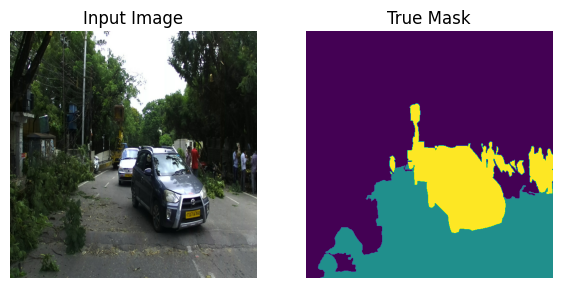

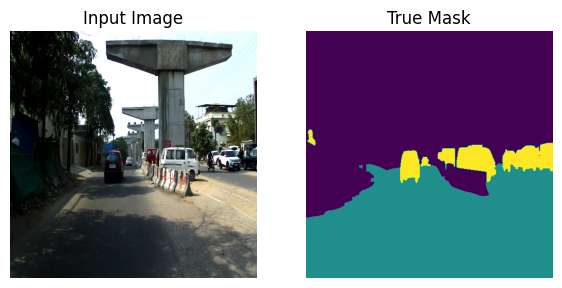

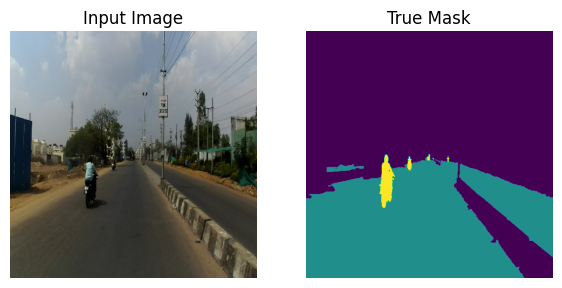

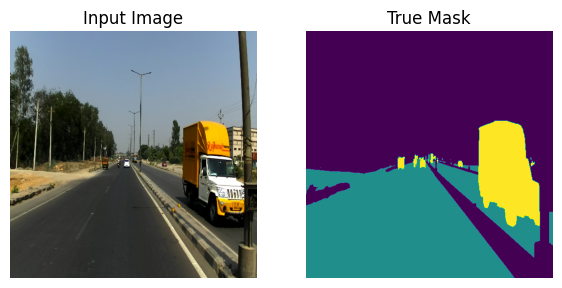

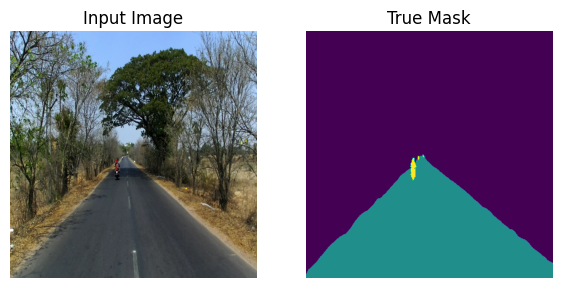

In [14]:
i=0
for image, mask in dataset['train'].take(5):
    i=i+1
#     print(i)
    sample_image, sample_mask = image, mask
    t = np.argmax(sample_mask[0],axis=-1)
    t = tf.expand_dims(t,axis=-1)
    display_sample([sample_image[0],t])

In [15]:
%env SM_FRAMEWORK=tf.keras

env: SM_FRAMEWORK=tf.keras


In [16]:
# -*- coding: utf-8 -*-

""" Deeplabv3+ model for Keras.
This model is based on TF repo:
https://github.com/tensorflow/models/tree/master/research/deeplab
On Pascal VOC, original model gets to 84.56% mIOU
MobileNetv2 backbone is based on this repo:
https://github.com/JonathanCMitchell/mobilenet_v2_keras
# Reference
- [Encoder-Decoder with Atrous Separable Convolution
    for Semantic Image Segmentation](https://arxiv.org/pdf/1802.02611.pdf)
- [Xception: Deep Learning with Depthwise Separable Convolutions]
    (https://arxiv.org/abs/1610.02357)
- [Inverted Residuals and Linear Bottlenecks: Mobile Networks for
    Classification, Detection and Segmentation](https://arxiv.org/abs/1801.04381)
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

from tensorflow.python.keras.models import Model
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input
from tensorflow.python.keras.layers import Reshape
from tensorflow.python.keras.layers import Activation
from tensorflow.python.keras.layers import Concatenate
from tensorflow.python.keras.layers import Add
from tensorflow.python.keras.layers import Dropout
from tensorflow.python.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Conv2D
from tensorflow.python.keras.layers import DepthwiseConv2D
from tensorflow.python.keras.layers import ZeroPadding2D
from tensorflow.python.keras.layers import GlobalAveragePooling2D
from tensorflow.python.keras.utils.layer_utils import get_source_inputs
from tensorflow.python.keras.utils.data_utils import get_file
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.applications.imagenet_utils import preprocess_input

WEIGHTS_PATH_X = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5"
WEIGHTS_PATH_MOBILE = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.1/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5"

WEIGHTS_PATH_X_CS = "https://github.com/bonlime/keras-deeplab-v3-plus/releases/download/1.2/deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5"
WEIGHTS_PATH_MOBILE_CS = "pretrained_weights/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5"


def SepConv_BN(x, filters, prefix, stride=1, kernel_size=3, rate=1, depth_activation=False, epsilon=1e-3):
    """ SepConv with BN between depthwise & pointwise. Optionally add activation after BN
        Implements right "same" padding for even kernel sizes
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & poinwise convs
            epsilon: epsilon to use in BN layer
    """

    if stride == 1:
        depth_padding = 'same'
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        depth_padding = 'valid'

    if not depth_activation:
        x = Activation(tf.nn.relu)(x)
    x = DepthwiseConv2D((kernel_size, kernel_size), strides=(stride, stride), dilation_rate=(rate, rate),
                        padding=depth_padding, use_bias=False, name=prefix + '_depthwise')(x)
    x = BatchNormalization(name=prefix + '_depthwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation(tf.nn.relu)(x)
    x = Conv2D(filters, (1, 1), padding='same',
               use_bias=False, name=prefix + '_pointwise')(x)
    x = BatchNormalization(name=prefix + '_pointwise_BN', epsilon=epsilon)(x)
    if depth_activation:
        x = Activation(tf.nn.relu)(x)

    return x


def _conv2d_same(x, filters, prefix, stride=1, kernel_size=3, rate=1):
    """Implements right 'same' padding for even kernel sizes
        Without this there is a 1 pixel drift when stride = 2
        Args:
            x: input tensor
            filters: num of filters in pointwise convolution
            prefix: prefix before name
            stride: stride at depthwise conv
            kernel_size: kernel size for depthwise convolution
            rate: atrous rate for depthwise convolution
    """
    if stride == 1:
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='same', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)
    else:
        kernel_size_effective = kernel_size + (kernel_size - 1) * (rate - 1)
        pad_total = kernel_size_effective - 1
        pad_beg = pad_total // 2
        pad_end = pad_total - pad_beg
        x = ZeroPadding2D((pad_beg, pad_end))(x)
        return Conv2D(filters,
                      (kernel_size, kernel_size),
                      strides=(stride, stride),
                      padding='valid', use_bias=False,
                      dilation_rate=(rate, rate),
                      name=prefix)(x)


def _xception_block(inputs, depth_list, prefix, skip_connection_type, stride,
                    rate=1, depth_activation=False, return_skip=False):
    """ Basic building block of modified Xception network
        Args:
            inputs: input tensor
            depth_list: number of filters in each SepConv layer. len(depth_list) == 3
            prefix: prefix before name
            skip_connection_type: one of {'conv','sum','none'}
            stride: stride at last depthwise conv
            rate: atrous rate for depthwise convolution
            depth_activation: flag to use activation between depthwise & pointwise convs
            return_skip: flag to return additional tensor after 2 SepConvs for decoder
            """
    residual = inputs
    for i in range(3):
        residual = SepConv_BN(residual,
                              depth_list[i],
                              prefix + '_separable_conv{}'.format(i + 1),
                              stride=stride if i == 2 else 1,
                              rate=rate,
                              depth_activation=depth_activation)
        if i == 1:
            skip = residual
    if skip_connection_type == 'conv':
        shortcut = _conv2d_same(inputs, depth_list[-1], prefix + '_shortcut',
                                kernel_size=1,
                                stride=stride)
        shortcut = BatchNormalization(name=prefix + '_shortcut_BN')(shortcut)
        outputs = layers.add([residual, shortcut])
    elif skip_connection_type == 'sum':
        outputs = layers.add([residual, inputs])
    elif skip_connection_type == 'none':
        outputs = residual
    if return_skip:
        return outputs, skip
    else:
        return outputs


def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id, skip_connection, rate=1):
    in_channels = inputs.shape[-1]#.value  # inputs._keras_shape[-1]
    pointwise_conv_filters = int(filters * alpha)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8)
    x = inputs
    prefix = 'expanded_conv_{}_'.format(block_id)
    if block_id:
        # Expand

        x = Conv2D(expansion * in_channels, kernel_size=1, padding='same',
                   use_bias=False, activation=None,
                   name=prefix + 'expand')(x)
        x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                               name=prefix + 'expand_BN')(x)
        x = Activation(tf.nn.relu6, name=prefix + 'expand_relu')(x)
    else:
        prefix = 'expanded_conv_'
    # Depthwise
    x = DepthwiseConv2D(kernel_size=3, strides=stride, activation=None,
                        use_bias=False, padding='same', dilation_rate=(rate, rate),
                        name=prefix + 'depthwise')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'depthwise_BN')(x)

    x = Activation(tf.nn.relu6, name=prefix + 'depthwise_relu')(x)

    # Project
    x = Conv2D(pointwise_filters,
               kernel_size=1, padding='same', use_bias=False, activation=None,
               name=prefix + 'project')(x)
    x = BatchNormalization(epsilon=1e-3, momentum=0.999,
                           name=prefix + 'project_BN')(x)

    if skip_connection:
        return Add(name=prefix + 'add')([inputs, x])

    # if in_channels == pointwise_filters and stride == 1:
    #    return Add(name='res_connect_' + str(block_id))([inputs, x])

    return x


def Deeplabv3(weights='pascal_voc', input_tensor=None, input_shape=(512, 512, 3), classes=21, backbone='mobilenetv2',
              OS=16, alpha=1., activation=None):
    """ Instantiates the Deeplabv3+ architecture
    Optionally loads weights pre-trained
    on PASCAL VOC or Cityscapes. This model is available for TensorFlow only.
    # Arguments
        weights: one of 'pascal_voc' (pre-trained on pascal voc),
            'cityscapes' (pre-trained on cityscape) or None (random initialization)
        input_tensor: optional Keras tensor (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: shape of input image. format HxWxC
            PASCAL VOC model was trained on (512,512,3) images. None is allowed as shape/width
        classes: number of desired classes. PASCAL VOC has 21 classes, Cityscapes has 19 classes.
            If number of classes not aligned with the weights used, last layer is initialized randomly
        backbone: backbone to use. one of {'xception','mobilenetv2'}
        activation: optional activation to add to the top of the network.
            One of 'softmax', 'sigmoid' or None
        OS: determines input_shape/feature_extractor_output ratio. One of {8,16}.
            Used only for xception backbone.
        alpha: controls the width of the MobileNetV2 network. This is known as the
            width multiplier in the MobileNetV2 paper.
                - If `alpha` < 1.0, proportionally decreases the number
                    of filters in each layer.
                - If `alpha` > 1.0, proportionally increases the number
                    of filters in each layer.
                - If `alpha` = 1, default number of filters from the paper
                    are used at each layer.
            Used only for mobilenetv2 backbone. Pretrained is only available for alpha=1.
    # Returns
        A Keras model instance.
    # Raises
        RuntimeError: If attempting to run this model with a
            backend that does not support separable convolutions.
        ValueError: in case of invalid argument for `weights` or `backbone`
    """

    if not (weights in {'pascal_voc', 'cityscapes', None}):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `pascal_voc`, or `cityscapes` '
                         '(pre-trained on PASCAL VOC)')

    if not (backbone in {'xception', 'mobilenetv2'}):
        raise ValueError('The `backbone` argument should be either '
                         '`xception`  or `mobilenetv2` ')

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        img_input = input_tensor

    if backbone == 'xception':
        if OS == 8:
            entry_block3_stride = 1
            middle_block_rate = 2  # ! Not mentioned in paper, but required
            exit_block_rates = (2, 4)
            atrous_rates = (12, 24, 36)
        else:
            entry_block3_stride = 2
            middle_block_rate = 1
            exit_block_rates = (1, 2)
            atrous_rates = (6, 12, 18)

        x = Conv2D(32, (3, 3), strides=(2, 2),
                   name='entry_flow_conv1_1', use_bias=False, padding='same')(img_input)
        x = BatchNormalization(name='entry_flow_conv1_1_BN')(x)
        x = Activation(tf.nn.relu)(x)

        x = _conv2d_same(x, 64, 'entry_flow_conv1_2', kernel_size=3, stride=1)
        x = BatchNormalization(name='entry_flow_conv1_2_BN')(x)
        x = Activation(tf.nn.relu)(x)

        x = _xception_block(x, [128, 128, 128], 'entry_flow_block1',
                            skip_connection_type='conv', stride=2,
                            depth_activation=False)
        x, skip1 = _xception_block(x, [256, 256, 256], 'entry_flow_block2',
                                   skip_connection_type='conv', stride=2,
                                   depth_activation=False, return_skip=True)

        x = _xception_block(x, [728, 728, 728], 'entry_flow_block3',
                            skip_connection_type='conv', stride=entry_block3_stride,
                            depth_activation=False)
        for i in range(16):
            x = _xception_block(x, [728, 728, 728], 'middle_flow_unit_{}'.format(i + 1),
                                skip_connection_type='sum', stride=1, rate=middle_block_rate,
                                depth_activation=False)

        x = _xception_block(x, [728, 1024, 1024], 'exit_flow_block1',
                            skip_connection_type='conv', stride=1, rate=exit_block_rates[0],
                            depth_activation=False)
        x = _xception_block(x, [1536, 1536, 2048], 'exit_flow_block2',
                            skip_connection_type='none', stride=1, rate=exit_block_rates[1],
                            depth_activation=True)

    else:
        OS = 8
        first_block_filters = _make_divisible(32 * alpha, 8)
        x = Conv2D(first_block_filters,
                   kernel_size=3,
                   strides=(2, 2), padding='same', use_bias=False,
                   name='Conv' if input_shape[2] == 3 else 'Conv_')(img_input)
        x = BatchNormalization(
            epsilon=1e-3, momentum=0.999, name='Conv_BN')(x)
        x = Activation(tf.nn.relu6, name='Conv_Relu6')(x)

        x = _inverted_res_block(x, filters=16, alpha=alpha, stride=1,
                                expansion=1, block_id=0, skip_connection=False)

        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=2,
                                expansion=6, block_id=1, skip_connection=False)
        x = _inverted_res_block(x, filters=24, alpha=alpha, stride=1,
                                expansion=6, block_id=2, skip_connection=True)

        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=2,
                                expansion=6, block_id=3, skip_connection=False)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=4, skip_connection=True)
        x = _inverted_res_block(x, filters=32, alpha=alpha, stride=1,
                                expansion=6, block_id=5, skip_connection=True)

        # stride in block 6 changed from 2 -> 1, so we need to use rate = 2
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1,  # 1!
                                expansion=6, block_id=6, skip_connection=False)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=7, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=8, skip_connection=True)
        x = _inverted_res_block(x, filters=64, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=9, skip_connection=True)

        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=10, skip_connection=False)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=11, skip_connection=True)
        x = _inverted_res_block(x, filters=96, alpha=alpha, stride=1, rate=2,
                                expansion=6, block_id=12, skip_connection=True)

        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=2,  # 1!
                                expansion=6, block_id=13, skip_connection=False)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=14, skip_connection=True)
        x = _inverted_res_block(x, filters=160, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=15, skip_connection=True)

        x = _inverted_res_block(x, filters=320, alpha=alpha, stride=1, rate=4,
                                expansion=6, block_id=16, skip_connection=False)

    # end of feature extractor

    # branching for Atrous Spatial Pyramid Pooling

    # Image Feature branch
    shape_before = tf.shape(x)
    b4 = GlobalAveragePooling2D()(x)
    b4_shape = tf.keras.backend.int_shape(b4)
    # from (b_size, channels)->(b_size, 1, 1, channels)
    b4 = Reshape((1, 1, b4_shape[1]))(b4)
    b4 = Conv2D(256, (1, 1), padding='same',
                use_bias=False, name='image_pooling')(b4)
    b4 = BatchNormalization(name='image_pooling_BN', epsilon=1e-5)(b4)
    b4 = Activation(tf.nn.relu)(b4)
    # upsample. have to use compat because of the option align_corners
    size_before = tf.keras.backend.int_shape(x)
    b4 = tf.keras.layers.experimental.preprocessing.Resizing(
            *size_before[1:3], interpolation="bilinear"
        )(b4)
    # simple 1x1
    b0 = Conv2D(256, (1, 1), padding='same', use_bias=False, name='aspp0')(x)
    b0 = BatchNormalization(name='aspp0_BN', epsilon=1e-5)(b0)
    b0 = Activation(tf.nn.relu, name='aspp0_activation')(b0)

    # there are only 2 branches in mobilenetV2. not sure why
    if backbone == 'xception':
        # rate = 6 (12)
        b1 = SepConv_BN(x, 256, 'aspp1',
                        rate=atrous_rates[0], depth_activation=True, epsilon=1e-5)
        # rate = 12 (24)
        b2 = SepConv_BN(x, 256, 'aspp2',
                        rate=atrous_rates[1], depth_activation=True, epsilon=1e-5)
        # rate = 18 (36)
        b3 = SepConv_BN(x, 256, 'aspp3',
                        rate=atrous_rates[2], depth_activation=True, epsilon=1e-5)

        # concatenate ASPP branches & project
        x = Concatenate()([b4, b0, b1, b2, b3])
    else:
        x = Concatenate()([b4, b0])

    x = Conv2D(256, (1, 1), padding='same',
               use_bias=False, name='concat_projection')(x)
    x = BatchNormalization(name='concat_projection_BN', epsilon=1e-5)(x)
    x = Activation(tf.nn.relu)(x)
    x = Dropout(0.1)(x)
    # DeepLab v.3+ decoder

    if backbone == 'xception':
        # Feature projection
        # x4 (x2) block
        skip_size = tf.keras.backend.int_shape(skip1)
        x = tf.keras.layers.experimental.preprocessing.Resizing(
                *skip_size[1:3], interpolation="bilinear"
            )(x)
        dec_skip1 = Conv2D(48, (1, 1), padding='same',
                           use_bias=False, name='feature_projection0')(skip1)
        dec_skip1 = BatchNormalization(
            name='feature_projection0_BN', epsilon=1e-5)(dec_skip1)
        dec_skip1 = Activation(tf.nn.relu)(dec_skip1)
        x = Concatenate()([x, dec_skip1])
        x = SepConv_BN(x, 256, 'decoder_conv0',
                       depth_activation=True, epsilon=1e-5)
        x = SepConv_BN(x, 256, 'decoder_conv1',
                       depth_activation=True, epsilon=1e-5)

    # you can use it with arbitary number of classes
    if (weights == 'pascal_voc' and classes == 21) or (weights == 'cityscapes' and classes == 19):
        last_layer_name = 'logits_semantic'
    else:
        last_layer_name = 'custom_logits_semantic'

    x = Conv2D(classes, (1, 1), padding='same', name=last_layer_name)(x)
    size_before3 = tf.keras.backend.int_shape(img_input)
    x = tf.keras.layers.experimental.preprocessing.Resizing(
            *size_before3[1:3], interpolation="bilinear"
        )(x)
    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input

    if activation in {'softmax', 'sigmoid'}:
        x = tf.keras.layers.Activation(activation)(x)

    model = Model(inputs, x, name='deeplabv3plus')

    # load weights

    if weights == 'pascal_voc':
        if backbone == 'xception':
            weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_X,
                                    cache_subdir='models')
        else:
            weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels.h5',
                                    WEIGHTS_PATH_MOBILE,
                                    cache_subdir='models')
        model.load_weights(weights_path, by_name=True)
    elif weights == 'cityscapes':
        if backbone == 'xception':
#             weights_path = get_file('deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5',
#                                     WEIGHTS_PATH_X_CS,
#                                     cache_subdir='models')
            weights_path = "pretrained_weights/deeplabv3_xception_tf_dim_ordering_tf_kernels_cityscapes.h5"    
        else:
#             weights_path = get_file('deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5',
#                                     WEIGHTS_PATH_MOBILE_CS,
#                                     cache_subdir='models')
           weights_path = "pretrained_weights/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5"
            
        model.load_weights(weights_path, by_name=True)
    return model

def preprocess_input(x):
    """Preprocesses a numpy array encoding a batch of images.
    # Arguments
        x: a 4D numpy array consists of RGB values within [0, 255].
    # Returns
        Input array scaled to [-1.,1.]
    """
    return preprocess_input(x, mode='tf')

In [18]:
from segmentation_models.losses import cce_jaccard_loss, dice_loss, JaccardLoss
from segmentation_models.metrics import iou_score, f1_score, precision, recall
ls = dice_loss + cce_jaccard_loss
metrics = [precision, recall, f1_score, iou_score] 

from tensorflow.keras.models import load_model
model = load_model('IDD_mobilenetV2_edge/ckpt_path/350.h5',
                   custom_objects={'dice_loss_plus_categorical_crossentropy_plus_jaccard_loss':ls,
                                   'precision':precision, 'recall':recall, 'f1-score':f1_score, 'iou_score':iou_score})

Segmentation Models: using `tf.keras` framework.


In [17]:
# model = Deeplabv3(weights="cityscapes", input_shape=(512,512,3), classes=3, 
#                   backbone= 'mobilenetv2', #'xception'
#                   OS=16, alpha=1.0, activation='softmax')
# model.load_weights('pretrained_weights/deeplabv3_mobilenetv2_tf_dim_ordering_tf_kernels_cityscapes.h5')

In [19]:
import os, time, keras
%env SM_FRAMEWORK=tf.keras

import numpy as np
import tensorflow as tf
from segmentation_models.losses import cce_jaccard_loss, dice_loss, JaccardLoss
from segmentation_models.metrics import iou_score, f1_score, precision, recall
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

""" Hyperparamaters """
batch_size = 16
epochs = 1000
base_dir = 'IDD_mobilenetV2_edge'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    os.mkdir(f"{base_dir}/ckpt_path")
    
csv_path = f"{base_dir}/history.csv"

""" callbacks """
root_logdir = os.path.join(os.curdir, f"{base_dir}/logs","fit","")
def get_run_logdir():
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)
run_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir, histogram_freq=1,profile_batch='10,15')

checkpoint_filepath = f'{base_dir}/'+'ckpt_path/{epoch}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    # monitor='val_iou_score',
    # mode='max',
    verbose = 1,
    period = 25,
    save_best_only=False
    )

callbacks = [
    model_checkpoint_callback,
    ReduceLROnPlateau(monitor="val_loss", patience=5, factor=0.1, verbose=1),
    CSVLogger(csv_path),
#     EarlyStopping(monitor="val_loss", patience=10),
    tensorboard_cb
]

""" steps per epochs """
train_steps = len(train_x)//batch_size
if len(train_x) % batch_size != 0:
    train_steps += 1

test_steps = len(val_x)//batch_size
if len(val_x) % batch_size != 0:
    test_steps += 1

print("train_steps", train_steps, "test_steps",test_steps)

# """ Model training """
# for layer in model.layers:
#     if layer.name == "global_average_pooling2d":
#         break
#     else:
#         layer.trainable = False

# for layer in model.layers:
#     print(layer.name,layer.trainable)

model.compile(
    loss=ls,
    optimizer= "Nadam",
    metrics=metrics
)
# model.summary()

env: SM_FRAMEWORK=tf.keras
train_steps 310 test_steps 64


In [20]:
history = model.fit(
    dataset["train"],
    validation_data=dataset["val"],
    epochs=2000,
    initial_epoch = 350,
    steps_per_epoch=train_steps,
    validation_steps=test_steps,
    callbacks=callbacks
)

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 351/2000
310/310 [==============================] - 146s 440ms/step - loss: 0.1546 - precision: 0.9552 - recall: 0.9568 - f1-score: 0.9560 - iou_score: 0.9179 - val_loss: 0.2922 - val_precision: 0.9249 - val_recall: 0.9195 - val_f1-score: 0.9220 - val_iou_score: 0.8613 - lr: 0.0010
Epoch 352/2000
310/310 [==============================] - 129s 416ms/step - loss: 0.1544 - precision: 0.9552 - recall: 0.9570 - f1-score: 0.9561 - iou_score: 0.9180 - val_loss: 0.2905 - val_precision: 0.9251 - val_recall: 0.9196 - val_f1-score: 0.9221 - val_iou_score: 0.8613 - lr: 0.0010
Epoch 353/2000
310/310 [==============================] - 132s 424ms/step - loss: 0.1546 - precision: 0.9551 - recall: 0.9569 - f1-score: 0.9560 - iou_score: 0.9179 - val_loss: 0.2915 - val_precision: 0.9240 - val_recall: 0.9202 - val_f1-score: 0.9219 - val_iou_score: 0.8611 - lr: 0.0010
Epoch 354/2000
310/310 [==============================] - 128s 413ms/step - loss: 0.1540 - precision: 0.9554 - recall: 0.9571 - f1-sc

Epoch 377/2000
310/310 [==============================] - ETA: 0s - loss: 0.1484 - precision: 0.9570 - recall: 0.9586 - f1-score: 0.9578 - iou_score: 0.9210
Epoch 00377: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
310/310 [==============================] - 128s 412ms/step - loss: 0.1484 - precision: 0.9570 - recall: 0.9586 - f1-score: 0.9578 - iou_score: 0.9210 - val_loss: 0.2901 - val_precision: 0.9238 - val_recall: 0.9212 - val_f1-score: 0.9223 - val_iou_score: 0.8618 - lr: 1.0000e-05
Epoch 378/2000
310/310 [==============================] - 128s 412ms/step - loss: 0.1489 - precision: 0.9568 - recall: 0.9585 - f1-score: 0.9576 - iou_score: 0.9208 - val_loss: 0.2895 - val_precision: 0.9243 - val_recall: 0.9217 - val_f1-score: 0.9228 - val_iou_score: 0.8625 - lr: 1.0000e-06
Epoch 379/2000
310/310 [==============================] - 128s 412ms/step - loss: 0.1486 - precision: 0.9569 - recall: 0.9586 - f1-score: 0.9577 - iou_score: 0.9209 - val_loss: 0.2884 - val_p

Epoch 401/2000
310/310 [==============================] - 127s 409ms/step - loss: 0.1482 - precision: 0.9570 - recall: 0.9587 - f1-score: 0.9579 - iou_score: 0.9212 - val_loss: 0.2910 - val_precision: 0.9235 - val_recall: 0.9215 - val_f1-score: 0.9223 - val_iou_score: 0.8618 - lr: 1.0000e-10
Epoch 402/2000
310/310 [==============================] - ETA: 0s - loss: 0.1483 - precision: 0.9569 - recall: 0.9588 - f1-score: 0.9578 - iou_score: 0.9211
Epoch 00402: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-11.
310/310 [==============================] - 128s 414ms/step - loss: 0.1483 - precision: 0.9569 - recall: 0.9588 - f1-score: 0.9578 - iou_score: 0.9211 - val_loss: 0.2888 - val_precision: 0.9245 - val_recall: 0.9221 - val_f1-score: 0.9231 - val_iou_score: 0.8627 - lr: 1.0000e-10
Epoch 403/2000
310/310 [==============================] - 128s 413ms/step - loss: 0.1486 - precision: 0.9569 - recall: 0.9586 - f1-score: 0.9577 - iou_score: 0.9209 - val_loss: 0.2896 - val_pr

310/310 [==============================] - ETA: 0s - loss: 0.1487 - precision: 0.9569 - recall: 0.9585 - f1-score: 0.9577 - iou_score: 0.9209
Epoch 00449: ReduceLROnPlateau reducing learning rate to 1.000000032889008e-20.
310/310 [==============================] - 128s 411ms/step - loss: 0.1487 - precision: 0.9569 - recall: 0.9585 - f1-score: 0.9577 - iou_score: 0.9209 - val_loss: 0.2891 - val_precision: 0.9246 - val_recall: 0.9220 - val_f1-score: 0.9231 - val_iou_score: 0.8628 - lr: 1.0000e-19
Epoch 450/2000
310/310 [==============================] - ETA: 0s - loss: 0.1487 - precision: 0.9569 - recall: 0.9585 - f1-score: 0.9577 - iou_score: 0.9208
Epoch 00450: saving model to IDD_mobilenetV2_edge/ckpt_path/450.h5
310/310 [==============================] - 127s 410ms/step - loss: 0.1487 - precision: 0.9569 - recall: 0.9585 - f1-score: 0.9577 - iou_score: 0.9208 - val_loss: 0.2901 - val_precision: 0.9238 - val_recall: 0.9219 - val_f1-score: 0.9226 - val_iou_score: 0.8621 - lr: 1.0000e-2

310/310 [==============================] - 128s 413ms/step - loss: 0.1484 - precision: 0.9570 - recall: 0.9587 - f1-score: 0.9578 - iou_score: 0.9210 - val_loss: 0.2897 - val_precision: 0.9241 - val_recall: 0.9215 - val_f1-score: 0.9226 - val_iou_score: 0.8622 - lr: 1.0000e-29
Epoch 496/2000
310/310 [==============================] - 127s 408ms/step - loss: 0.1494 - precision: 0.9568 - recall: 0.9582 - f1-score: 0.9575 - iou_score: 0.9205 - val_loss: 0.2899 - val_precision: 0.9241 - val_recall: 0.9214 - val_f1-score: 0.9226 - val_iou_score: 0.8622 - lr: 1.0000e-29
Epoch 497/2000
310/310 [==============================] - 127s 408ms/step - loss: 0.1485 - precision: 0.9570 - recall: 0.9586 - f1-score: 0.9578 - iou_score: 0.9210 - val_loss: 0.2882 - val_precision: 0.9248 - val_recall: 0.9223 - val_f1-score: 0.9234 - val_iou_score: 0.8632 - lr: 1.0000e-29
Epoch 498/2000
310/310 [==============================] - 127s 410ms/step - loss: 0.1487 - precision: 0.9569 - recall: 0.9585 - f1-score

310/310 [==============================] - 126s 406ms/step - loss: 0.1489 - precision: 0.9568 - recall: 0.9585 - f1-score: 0.9576 - iou_score: 0.9208 - val_loss: 0.2885 - val_precision: 0.9246 - val_recall: 0.9221 - val_f1-score: 0.9232 - val_iou_score: 0.8630 - lr: 1.0000e-38
Epoch 543/2000
310/310 [==============================] - 127s 408ms/step - loss: 0.1483 - precision: 0.9571 - recall: 0.9586 - f1-score: 0.9578 - iou_score: 0.9211 - val_loss: 0.2906 - val_precision: 0.9238 - val_recall: 0.9209 - val_f1-score: 0.9221 - val_iou_score: 0.8616 - lr: 1.0000e-38
Epoch 544/2000
310/310 [==============================] - ETA: 0s - loss: 0.1484 - precision: 0.9570 - recall: 0.9587 - f1-score: 0.9578 - iou_score: 0.9211
Epoch 00544: ReduceLROnPlateau reducing learning rate to 1.0000000751754869e-39.
310/310 [==============================] - 127s 408ms/step - loss: 0.1484 - precision: 0.9570 - recall: 0.9587 - f1-score: 0.9578 - iou_score: 0.9211 - val_loss: 0.2897 - val_precision: 0.924

310/310 [==============================] - 127s 409ms/step - loss: 0.1484 - precision: 0.9571 - recall: 0.9586 - f1-score: 0.9578 - iou_score: 0.9211 - val_loss: 0.2889 - val_precision: 0.9246 - val_recall: 0.9218 - val_f1-score: 0.9230 - val_iou_score: 0.8628 - lr: 0.0000e+00
Epoch 591/2000
310/310 [==============================] - 128s 411ms/step - loss: 0.1485 - precision: 0.9570 - recall: 0.9586 - f1-score: 0.9578 - iou_score: 0.9210 - val_loss: 0.2904 - val_precision: 0.9242 - val_recall: 0.9213 - val_f1-score: 0.9225 - val_iou_score: 0.8621 - lr: 0.0000e+00
Epoch 592/2000
310/310 [==============================] - 128s 412ms/step - loss: 0.1482 - precision: 0.9571 - recall: 0.9586 - f1-score: 0.9578 - iou_score: 0.9211 - val_loss: 0.2897 - val_precision: 0.9243 - val_recall: 0.9216 - val_f1-score: 0.9228 - val_iou_score: 0.8623 - lr: 0.0000e+00
Epoch 593/2000
310/310 [==============================] - 126s 406ms/step - loss: 0.1480 - precision: 0.9572 - recall: 0.9588 - f1-score

310/310 [==============================] - 127s 408ms/step - loss: 0.1488 - precision: 0.9568 - recall: 0.9586 - f1-score: 0.9577 - iou_score: 0.9209 - val_loss: 0.2900 - val_precision: 0.9244 - val_recall: 0.9215 - val_f1-score: 0.9227 - val_iou_score: 0.8623 - lr: 0.0000e+00
Epoch 645/2000
310/310 [==============================] - 128s 411ms/step - loss: 0.1488 - precision: 0.9568 - recall: 0.9585 - f1-score: 0.9577 - iou_score: 0.9208 - val_loss: 0.2894 - val_precision: 0.9243 - val_recall: 0.9216 - val_f1-score: 0.9227 - val_iou_score: 0.8624 - lr: 0.0000e+00
Epoch 646/2000
310/310 [==============================] - 128s 412ms/step - loss: 0.1488 - precision: 0.9569 - recall: 0.9585 - f1-score: 0.9577 - iou_score: 0.9209 - val_loss: 0.2904 - val_precision: 0.9239 - val_recall: 0.9215 - val_f1-score: 0.9225 - val_iou_score: 0.8620 - lr: 0.0000e+00
Epoch 647/2000
310/310 [==============================] - 126s 406ms/step - loss: 0.1487 - precision: 0.9570 - recall: 0.9585 - f1-score

310/310 [==============================] - 128s 411ms/step - loss: 0.1487 - precision: 0.9569 - recall: 0.9585 - f1-score: 0.9577 - iou_score: 0.9208 - val_loss: 0.2896 - val_precision: 0.9240 - val_recall: 0.9217 - val_f1-score: 0.9227 - val_iou_score: 0.8622 - lr: 0.0000e+00
Epoch 699/2000
310/310 [==============================] - 127s 408ms/step - loss: 0.1479 - precision: 0.9571 - recall: 0.9589 - f1-score: 0.9580 - iou_score: 0.9214 - val_loss: 0.2897 - val_precision: 0.9247 - val_recall: 0.9211 - val_f1-score: 0.9227 - val_iou_score: 0.8623 - lr: 0.0000e+00
Epoch 700/2000
310/310 [==============================] - ETA: 0s - loss: 0.1491 - precision: 0.9568 - recall: 0.9584 - f1-score: 0.9576 - iou_score: 0.9207
Epoch 00700: saving model to IDD_mobilenetV2_edge/ckpt_path/700.h5
310/310 [==============================] - 128s 412ms/step - loss: 0.1491 - precision: 0.9568 - recall: 0.9584 - f1-score: 0.9576 - iou_score: 0.9207 - val_loss: 0.2904 - val_precision: 0.9239 - val_recall

KeyboardInterrupt: 